## Neural network to predict daily Bike Ridership
#### Dataset downloaded from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
#### The project: https://github.com/udacity/deep-learning/tree/master/first-neural-network
### The Neural Network consist of 2 layers, hidden and output.The hidden layer has an activation function and uses sigmoid while the output layer consist of a single node and its activation is same as input to it ie. f(x)=x.

In [1]:
#Using Magic Functions for:
#inline plots
#autoreloading modules before execution
#retina display mode for plots and figures
%matplotlib inline                                  
%load_ext autoreload                                
%autoreload 2
%config InlineBackend.figure_format="retina"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing dataset

In [3]:
datarides=pd.read_csv("Datasets/hour.csv")

### One-hot encoding/ creating dummy variables

In [6]:
dummy_var=['season', 'weathersit', 'mnth', 'hr', 'weekday']
for var in dummy_var:
    datarides=pd.concat([datarides,pd.get_dummies(datarides[var],prefix=var,drop_first=False)],axis=1)

In [7]:
rides=datarides.drop(['season', 'weathersit', 'mnth', 'hr', 'weekday','instant', 'dteday','atemp',  'workingday'],axis=1)


In [8]:
rides.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling the data

In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features={}
for each in quant_features:
    mean,stnd=rides[each].mean(),rides[each].std()
    scaled_features[each]=mean,stnd
    rides.loc[:,each]=(rides[each]-mean)/stnd   #selecting the specific column and scaling the values

### Spliting the dataset into training, test and validation. The test dataset contains data for nearly 21 days while the remaining dataset is spliting further into training and validation. The validation dataset contains data for nearly 24 days while the remaining is the training dataset

In [10]:
#Spliting data
testdata=rides[-21*24:]
data=rides[:-21*24]

targ_var=['cnt','casual','registered']
features,targets=data.drop(targ_var,axis=1),data[targ_var]
testfeature,testtarget=testdata.drop(targ_var,axis=1),testdata[targ_var]

train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### Defining a Mean Squared Function

In [11]:
def mse(y, Y):
    return np.mean((y-Y)**2)

# Defining a neural network class
### with functions for training,forward propagation, backpropagation,weights updation and running.

In [12]:
class NeuralNetwork(object):
    def __init__(self,inputnodes,hiddennodes,outputnodes,learnrate):
        self.inputnodes=inputnodes
        self.hiddennodes=hiddennodes
        self.outputnodes=outputnodes
        self.weights_ih=np.random.normal(0.0,self.inputnodes**-0.5,(self.inputnodes,self.hiddennodes))
        self.weights_ho=np.random.normal(0.0,self.hiddennodes**-0.5,(self.hiddennodes,self.outputnodes))
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        self.activation_function=sigmoid
        self.lr=learnrate
    def train(self,features,target):
        
        records=features.shape[0]
        delta_wih=np.zeros(self.weights_ih.shape)
        delta_who=np.zeros(self.weights_ho.shape)
        for x,y in zip(features,target):
            finalout,hiddenout=self.forwardpass(x)
            delta_wih,delta_who=self.backprop(finalout,hiddenout,x,y,delta_wih,delta_who)
        self.update(delta_wih,delta_who,records)
        
    def forwardpass(self,x):
        hiddenout=self.activation_function(np.dot(x,self.weights_ih))
        finalout=np.dot(hiddenout,self.weights_ho)
        return finalout,hiddenout
    def backprop(self,finalout,hiddenout,x,y,delta_wih,delta_who):
        
        error=y-finalout
        # errorterm=error since there is no activation function in the output node
        hiddenerror=np.dot(self.weights_ho,error)
        hiddenerrorterm=hiddenerror*hiddenout*(1-hiddenout)
        
        delta_wih+=hiddenerrorterm*x[:,None] #x[:,None] creates axis with length 1
        delta_who+=error*hiddenout[:,None]
        
        return delta_wih,delta_who
    def update(self,delta_wih,delta_who,records):
        self.weights_ih+=self.lr*delta_wih/records
        self.weights_ho+=self.lr*delta_who/records
    
    def run(self,features):
        
        hiddenoutput=self.activation_function(np.dot(features,self.weights_ih))
        output=np.dot(hiddenoutput,self.weights_ho)
        
        return output

### Setting model hyperparameters

In [91]:
epoch=5000
hidnod=20
alpha=0.6
outnod=1

In [92]:
network=NeuralNetwork(features.shape[1],hidnod,outnod,alpha)

## Training the network

In [93]:
losses={'train':[],'validation':[]}
for i in range(epoch):
    batch=np.random.choice(train_features.index,size=150)
    x,y=train_features.ix[batch].values,train_targets.ix[batch]['cnt']
    
    network.train(x,y)
    trainloss=mse(network.run(train_features).T,train_targets['cnt'].values)
    testloss=mse(network.run(val_features).T,val_targets['cnt'].values)
    print("\rProgress:{:2.1f}".format(100*(i/float(epoch))),end="")

    losses['train'].append(trainloss)
    losses['validation'].append(testloss)

C:\Users\ABC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Progress:100.0

## Plotting the training and validation loss

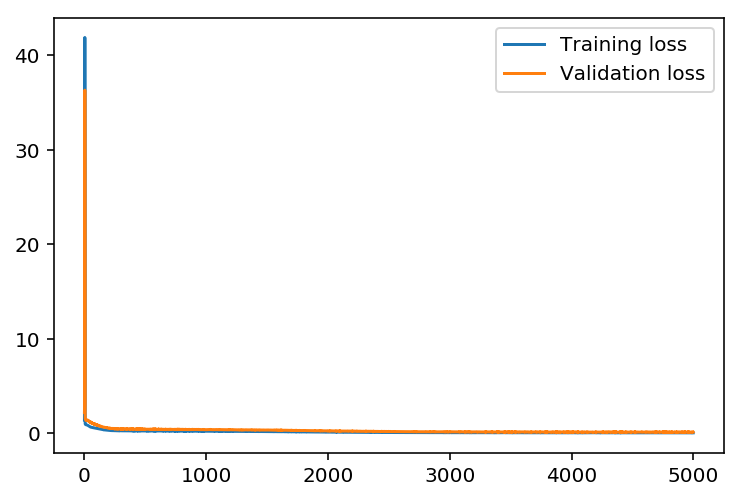

In [94]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Checking predictions with the test data

C:\Users\ABC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


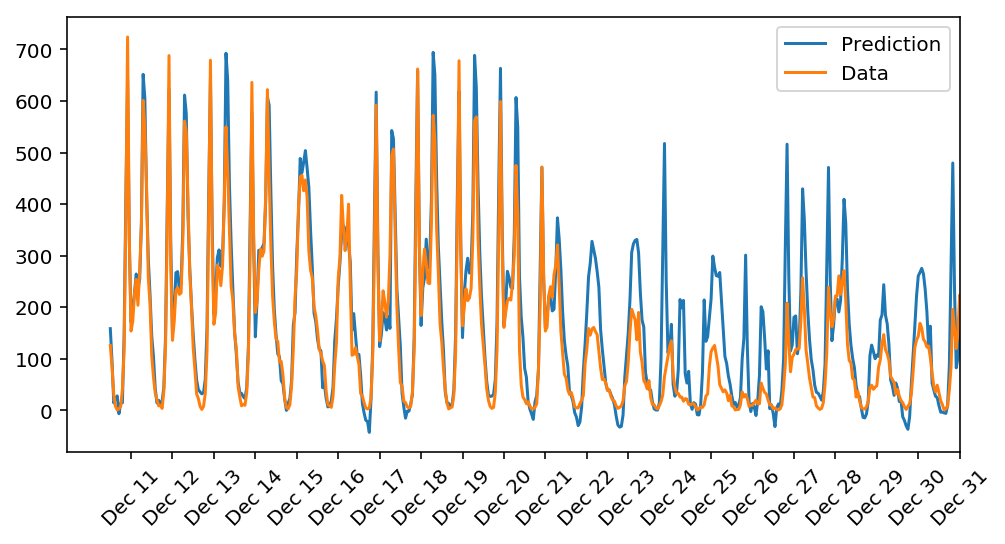

In [96]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(testfeature).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((testtarget['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(datarides.ix[testdata.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### We can see from the graph above that the model does a good predicting the values except for the last week of december,probably since it is holiday period,and the training data for holidays is relatively less.Hence,the model couldn't probably predict that well for that period.  

## Checking the model score using Sklearn's r2_score function

In [97]:
prez=network.run(testfeature)

In [104]:
from sklearn.metrics import r2_score
score =r2_score(testtarget['cnt'].values,prez)


In [105]:
score

0.7481503096595252